In [2]:
import os
import random
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

print("Label Visualization Script Starting...")

Label Visualization Script Starting...


In [3]:
# Define classes and colors
CLASSES = [
    "COMPANY", "ADDRESS", "DATE", "TOTAL", "TAX", "ITEM", 
    "QTY", "UNIT_PRICE", "LINE_TOTAL", "DOCUMENT_NO", "CASHIER", "OTHER"
]

# Define colors for each class (RGB tuples)
COLORS = [
    (255, 0, 0),      # COMPANY - Red
    (0, 255, 0),      # ADDRESS - Green
    (0, 0, 255),      # DATE - Blue
    (255, 255, 0),    # TOTAL - Yellow
    (255, 0, 255),    # TAX - Magenta
    (0, 255, 255),    # ITEM - Cyan
    (255, 128, 0),    # QTY - Orange
    (128, 255, 0),    # UNIT_PRICE - Lime
    (255, 0, 128),    # LINE_TOTAL - Pink
    (128, 0, 255),    # DOCUMENT_NO - Purple
    (0, 128, 255),    # CASHIER - Sky Blue
    (128, 128, 128)   # OTHER - Gray
]

# Normalize colors to 0-1 range for matplotlib
COLORS_NORM = [(r/255, g/255, b/255) for r, g, b in COLORS]

print(f"Using {len(CLASSES)} classes with distinct colors")

Using 12 classes with distinct colors


In [4]:
def yolo_to_bbox(x_center: float, y_center: float, width: float, height: float, img_w: int, img_h: int) -> Tuple[int, int, int, int]:
    """
    Convert YOLO normalized coordinates to absolute bounding box coordinates.
    
    Args:
        x_center, y_center, width, height: YOLO normalized coordinates
        img_w, img_h: Image dimensions
        
    Returns:
        Tuple of (xmin, ymin, xmax, ymax) in absolute coordinates
    """
    # Convert to absolute coordinates
    x_center_abs = x_center * img_w
    y_center_abs = y_center * img_h
    width_abs = width * img_w
    height_abs = height * img_h
    
    # Calculate bbox corners
    xmin = int(x_center_abs - width_abs / 2)
    ymin = int(y_center_abs - height_abs / 2)
    xmax = int(x_center_abs + width_abs / 2)
    ymax = int(y_center_abs + height_abs / 2)
    
    return xmin, ymin, xmax, ymax


def load_yolo_labels(label_file: str) -> List[Tuple[int, float, float, float, float]]:
    """
    Load YOLO format labels from file.
    
    Args:
        label_file: Path to YOLO label file
        
    Returns:
        List of tuples (class_id, x_center, y_center, width, height)
    """
    labels = []
    
    try:
        with open(label_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                parts = line.split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    
                    labels.append((class_id, x_center, y_center, width, height))
                    
    except Exception as e:
        print(f"Error loading labels from {label_file}: {e}")
    
    return labels

In [5]:
def visualize_image_with_labels(image_path: str, label_path: str, output_path: str, max_width: int = 1200) -> dict:
    """
    Visualize an image with its YOLO labels overlaid.
    
    Args:
        image_path: Path to image file
        label_path: Path to YOLO label file
        output_path: Path to save visualization
        max_width: Maximum width for display (to keep images readable)
        
    Returns:
        Dictionary with stats about the visualization
    """
    stats = {'total_labels': 0, 'class_counts': {cls: 0 for cls in CLASSES}, 'has_labels': False}
    
    try:
        # Load image
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            img_w, img_h = img.size
            
            # Scale image if too large
            scale_factor = 1.0
            if img_w > max_width:
                scale_factor = max_width / img_w
                new_w = int(img_w * scale_factor)
                new_h = int(img_h * scale_factor)
                img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
                display_w, display_h = new_w, new_h
            else:
                display_w, display_h = img_w, img_h
        
        # Load labels
        labels = load_yolo_labels(label_path)
        
        if not labels:
            print(f"Warning: No labels found for {Path(image_path).name}")
            return stats
        
        # Create figure
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(img)
        ax.set_title(f"Labels for {Path(image_path).name} ({len(labels)} objects)", fontsize=14)
        
        # Draw bounding boxes
        for class_id, x_center, y_center, width, height in labels:
            # Convert YOLO to bbox (using original image dimensions)
            xmin, ymin, xmax, ymax = yolo_to_bbox(x_center, y_center, width, height, img_w, img_h)
            
            # Scale to display dimensions
            xmin_disp = int(xmin * scale_factor)
            ymin_disp = int(ymin * scale_factor)
            xmax_disp = int(xmax * scale_factor)
            ymax_disp = int(ymax * scale_factor)
            
            # Get class info
            class_name = CLASSES[class_id] if class_id < len(CLASSES) else f"UNKNOWN_{class_id}"
            color = COLORS_NORM[class_id] if class_id < len(COLORS_NORM) else (0.5, 0.5, 0.5)
            
            # Draw rectangle
            rect = patches.Rectangle(
                (xmin_disp, ymin_disp),
                xmax_disp - xmin_disp,
                ymax_disp - ymin_disp,
                linewidth=2,
                edgecolor=color,
                facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add class label
            ax.text(
                xmin_disp, ymin_disp - 5,
                f"{class_name} ({class_id})",
                fontsize=8,
                color=color,
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8)
            )
            
            # Update stats
            stats['total_labels'] += 1
            stats['class_counts'][class_name] += 1
        
        stats['has_labels'] = True
        
        # Remove axes
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Save visualization
        plt.tight_layout()
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
        
    except Exception as e:
        print(f"Error visualizing {image_path}: {e}")
        plt.close()
    
    return stats

In [6]:
# Set up paths
images_dir = "../../dataset/images"
labels_dir = "../../dataset/labels"
output_dir = "../../debug_vis"
debug_report_file = "../../dataset/debug_report.txt"

# Configuration
N_SAMPLES = 20  # Number of samples to visualize
SEED = 42

# Create output directory
Path(output_dir).mkdir(parents=True, exist_ok=True)

print(f"Images directory: {images_dir}")
print(f"Labels directory: {labels_dir}")
print(f"Output directory: {output_dir}")
print(f"Visualizing {N_SAMPLES} samples")

Images directory: ../../dataset/images
Labels directory: ../../dataset/labels
Output directory: ../../debug_vis
Visualizing 20 samples


In [7]:
# Get all image files
image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
image_files = []

for ext in image_extensions:
    image_files.extend(Path(images_dir).glob(f"*{ext}"))

print(f"Found {len(image_files)} image files")

if len(image_files) == 0:
    print("Error: No image files found. Please run the previous notebooks first.")
else:
    # Select random sample
    random.seed(SEED)
    sample_images = random.sample(image_files, min(N_SAMPLES, len(image_files)))
    print(f"Selected {len(sample_images)} images for visualization")

Found 1252 image files
Selected 20 images for visualization


In [8]:
# Visualize sample images
all_stats = []
processed_count = 0
zero_label_images = []
high_other_images = []

print("\nCreating visualizations...")

for img_file in sample_images:
    stem = img_file.stem
    label_file = Path(labels_dir) / f"{stem}.txt"
    output_file = Path(output_dir) / f"{stem}_labeled.jpg"
    
    if not label_file.exists():
        print(f"Warning: No label file for {img_file.name}")
        zero_label_images.append(img_file.name)
        continue
    
    # Create visualization
    stats = visualize_image_with_labels(str(img_file), str(label_file), str(output_file))
    
    if stats['has_labels']:
        all_stats.append({
            'image': img_file.name,
            'total_labels': stats['total_labels'],
            'class_counts': stats['class_counts']
        })
        
        # Check for issues
        if stats['total_labels'] == 0:
            zero_label_images.append(img_file.name)
        
        other_ratio = stats['class_counts']['OTHER'] / max(stats['total_labels'], 1)
        if other_ratio > 0.5:  # More than 50% OTHER class
            high_other_images.append(img_file.name)
        
        processed_count += 1
        
        if processed_count % 5 == 0:
            print(f"Processed {processed_count} visualizations...")

print(f"\nCompleted {processed_count} visualizations")


Creating visualizations...
Processed 5 visualizations...
Processed 10 visualizations...
Processed 15 visualizations...
Processed 20 visualizations...

Completed 20 visualizations


In [9]:
# Generate debug report
with open(debug_report_file, 'w', encoding='utf-8') as f:
    f.write("DATASET DEBUG REPORT\n")
    f.write("=" * 50 + "\n")
    f.write(f"Generated from {len(sample_images)} sample images\n\n")
    
    # Overall statistics
    if all_stats:
        total_labels = sum(s['total_labels'] for s in all_stats)
        avg_labels = total_labels / len(all_stats)
        
        f.write(f"OVERALL STATISTICS:\n")
        f.write(f"- Images processed: {len(all_stats)}\n")
        f.write(f"- Total labels: {total_labels}\n")
        f.write(f"- Average labels per image: {avg_labels:.1f}\n\n")
        
        # Class distribution
        class_totals = {cls: 0 for cls in CLASSES}
        for stats in all_stats:
            for cls, count in stats['class_counts'].items():
                if cls in class_totals:
                    class_totals[cls] += count
        
        f.write("CLASS DISTRIBUTION:\n")
        for i, cls in enumerate(CLASSES):
            count = class_totals[cls]
            percentage = (count / total_labels * 100) if total_labels > 0 else 0
            f.write(f"  {i:2d}. {cls:12s}: {count:6d} ({percentage:5.1f}%)\n")
    
    # Issues found
    f.write("\nISSUES FOUND:\n")
    f.write(f"- Images with zero labels: {len(zero_label_images)}\n")
    if zero_label_images:
        f.write("  Files: " + ", ".join(zero_label_images[:10]) + "\n")
    
    f.write(f"- Images with >50% OTHER labels: {len(high_other_images)}\n")
    if high_other_images:
        f.write("  Files: " + ", ".join(high_other_images[:10]) + "\n")
    
    # Sample statistics
    f.write("\nSAMPLE IMAGE DETAILS:\n")
    for stats in all_stats[:10]:  # Show first 10
        f.write(f"- {stats['image']}: {stats['total_labels']} labels\n")
        top_classes = sorted(stats['class_counts'].items(), key=lambda x: x[1], reverse=True)
        top_3 = [f"{cls}({count})" for cls, count in top_classes[:3] if count > 0]
        f.write(f"  Top classes: {', '.join(top_3)}\n")

print(f"\nDebug report saved to: {debug_report_file}")


Debug report saved to: ../../dataset/debug_report.txt


In [10]:
# Print summary
print("\n" + "="*50)
print("LABEL VISUALIZATION SUMMARY")
print("="*50)
print(f"Sample images: {len(sample_images)}")
print(f"Visualizations created: {processed_count}")
print(f"Output directory: {output_dir}")

if all_stats:
    total_labels = sum(s['total_labels'] for s in all_stats)
    avg_labels = total_labels / len(all_stats)
    
    print(f"\nLabel Statistics:")
    print(f"  Total labels in sample: {total_labels}")
    print(f"  Average labels per image: {avg_labels:.1f}")
    
    # Show top classes
    class_totals = {cls: 0 for cls in CLASSES}
    for stats in all_stats:
        for cls, count in stats['class_counts'].items():
            if cls in class_totals:
                class_totals[cls] += count
    
    top_classes = sorted(class_totals.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nTop 5 classes in sample:")
    for cls, count in top_classes:
        percentage = (count / total_labels * 100) if total_labels > 0 else 0
        print(f"  {cls}: {count} ({percentage:.1f}%)")

print(f"\nPotential Issues:")
print(f"  Images with zero labels: {len(zero_label_images)}")
print(f"  Images with >50% OTHER labels: {len(high_other_images)}")

if high_other_images:
    print(f"\n⚠️  Consider reviewing classification rules if many images have high OTHER ratio")
    
print(f"\nFiles created:")
print(f"  Visualizations: {output_dir}/*.jpg")
print(f"  Debug report: {debug_report_file}")

print("\n" + "="*50)


LABEL VISUALIZATION SUMMARY
Sample images: 20
Visualizations created: 20
Output directory: ../../debug_vis

Label Statistics:
  Total labels in sample: 1030
  Average labels per image: 51.5

Top 5 classes in sample:
  OTHER: 249 (24.2%)
  ITEM: 244 (23.7%)
  LINE_TOTAL: 183 (17.8%)
  TAX: 115 (11.2%)
  QTY: 61 (5.9%)

Potential Issues:
  Images with zero labels: 0
  Images with >50% OTHER labels: 0

Files created:
  Visualizations: ../../debug_vis/*.jpg
  Debug report: ../../dataset/debug_report.txt




Showing 3 sample visualizations:


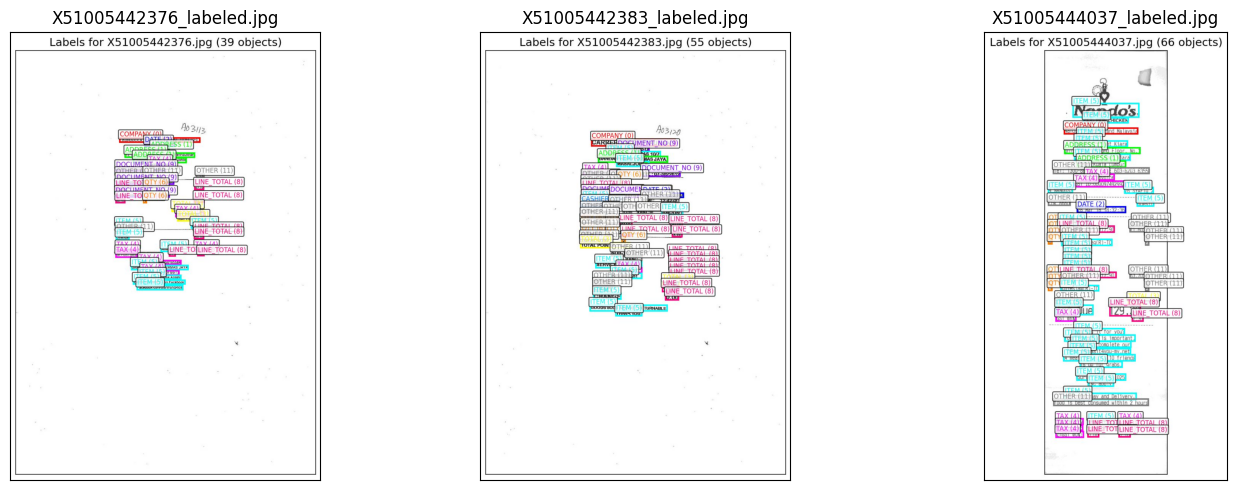


Full visualizations saved to: ../../debug_vis/


In [11]:
# Show some sample visualizations inline (if running in Jupyter)
sample_vis_files = list(Path(output_dir).glob("*.jpg"))[:3]

if sample_vis_files:
    print(f"\nShowing {len(sample_vis_files)} sample visualizations:")
    
    fig, axes = plt.subplots(1, min(3, len(sample_vis_files)), figsize=(15, 5))
    if len(sample_vis_files) == 1:
        axes = [axes]
    
    for i, vis_file in enumerate(sample_vis_files):
        img = Image.open(vis_file)
        axes[i].imshow(img)
        axes[i].set_title(vis_file.name)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFull visualizations saved to: {output_dir}/")